In [3]:
import pandas as pd
import datetime
import multiprocessing as mp
import numpy as np

In [4]:
%ls

 Volume in drive C is Windows
 Volume Serial Number is 0CF9-4541

 Directory of C:\Users\yzhhu\Desktop\Archive\Identifying Fraudulent Activities\Fraud

04/30/2020  10:57 PM    <DIR>          .
04/30/2020  10:57 PM    <DIR>          ..
04/25/2020  08:01 PM    <DIR>          .ipynb_checkpoints
04/30/2020  10:57 PM            60,497 fraud.ipynb
01/08/2016  05:02 PM        16,074,450 Fraud_Data.csv
01/08/2016  05:02 PM         4,894,783 IpAddress_to_Country.csv
               3 File(s)     21,029,730 bytes
               3 Dir(s)  214,885,933,056 bytes free


In [5]:
fraud=pd.read_csv('Fraud_Data.csv')
ip=pd.read_csv('IpAddress_to_Country.csv')

In [6]:
fraud.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [7]:
fraud['class'].value_counts() # really imbalanced data 

0    136961
1     14151
Name: class, dtype: int64

In [8]:
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [9]:
country=[]
for i in fraud.ip_address:
    temp=ip[(ip.lower_bound_ip_address<=i) & (ip.upper_bound_ip_address>=i)]
    if len(temp)!=0:
        country.append(temp.country.values[0])
    else:
        country.append('NA')

In [10]:
fraud['country']=country

In [11]:
fraud.drop(['ip_address'],axis=1,inplace=True)

In [12]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,0,United States


In [13]:
fraud['signup_time']=fraud.signup_time.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))



In [14]:
fraud['purchase_time']=fraud.purchase_time.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [15]:
fraud['purchase_day_night']=fraud.purchase_time.apply(lambda x: 'day' if (x.time()>datetime.time(7,0,0)) and (x.time()<datetime.time(19,0,0)) else 'night')

In [16]:
fraud['signup_day_night']=fraud.signup_time.apply(lambda x: 'day' if (x.time()>datetime.time(7,0,0)) and (x.time()<datetime.time(19,0,0)) else 'night')

In [17]:
fraud['purchase_since_signup']=(fraud['purchase_time']-fraud['signup_time']).apply(lambda x:x.days)

In [18]:
device_dict={i:j for i,j in zip(fraud.device_id.value_counts(sort=False).index,fraud.device_id.value_counts(sort=False).values)}

In [19]:
lst=[device_dict[i] for i in fraud.device_id]
    

In [20]:
fraud['num_device_popup']=pd.Series(lst)

In [21]:
fraud2=fraud.drop(['signup_time','purchase_time','user_id','device_id'],axis=1)

In [22]:
fraud2.head()

,purchase_value,source,browser,sex,age,class,country,purchase_day_night,signup_day_night,purchase_since_signup,num_device_popup
0,34,SEO,Chrome,M,39,0,Japan,night,night,52,1
1,16,Ads,Chrome,F,53,0,United States,night,night,0,1
2,15,SEO,Opera,M,53,1,United States,day,day,0,12
3,44,SEO,Safari,M,41,0,NA,day,night,5,1
4,39,Ads,Safari,M,45,0,United States,day,day,50,1


In [23]:
cateforical=[i for i in fraud2.columns if fraud2[i].dtype=='object']

In [24]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [25]:
cateforical

['source',
 'browser',
 'sex',
 'country',
 'purchase_day_night',
 'signup_day_night']

In [26]:
for i in cateforical:
    fraud2[i]=le.fit_transform(fraud2[i])

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
fraud2

,purchase_value,source,browser,sex,age,class,country,purchase_day_night,signup_day_night,purchase_since_signup,num_device_popup
0,34,2,0,1,39,0,84,1,1,52,1
1,16,0,0,0,53,0,172,1,1,0,1
2,15,2,3,1,53,1,172,0,0,0,12
3,44,2,4,1,41,0,115,0,1,5,1
4,39,0,4,1,45,0,172,0,0,50,1
...,...,...,...,...,...,...,...,...,...,...,...
151107,43,2,0,1,28,1,172,1,1,60,2
151108,35,2,4,1,32,0,119,0,0,10,1
151109,40,2,2,0,26,0,84,0,1,77,1
151110,46,2,0,1,37,0,172,0,1,59,2


In [77]:
x=fraud2.drop(['class'],axis=1)
y=fraud2['class']

In [78]:
y.value_counts()[1]/y.value_counts()[0]

0.10332138345952498

In [108]:
x_train, x_test, y_train, y_test = train_test_split(
 x, y, test_size=0.2, random_state=42)

# Balanced lr

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
lr=LogisticRegression(class_weight='balanced')
lr.fit(x_train,y_train)
pred=lr.predict(x_test)
print(classification_report(y_test, pred))
confusion_matrix(y_test,pred)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     27373
           1       0.66      0.62      0.64      2850

    accuracy                           0.93     30223
   macro avg       0.81      0.79      0.80     30223
weighted avg       0.93      0.93      0.93     30223



C:\Users\yzhhu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[26468,   905],
       [ 1084,  1766]], dtype=int64)

In [110]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,pred)

0.793293673302095

# cv balanced grid rf

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf=RandomForestClassifier(class_weight='balanced')
parameters={'n_estimators':[10,30,50,100],
            'bootstrap':[True,False],
            'max_depth':[3,6,9]
            }
clf = GridSearchCV(rf, parameters,cv=3,scoring='f1',n_jobs=-1)
clf.fit(x_train,y_train)
pred=clf.best_estimator_.predict(x_test)
print(classification_report(y_test, pred))
confusion_matrix(y_test,pred)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     27373
           1       0.56      0.71      0.63      2850

    accuracy                           0.92     30223
   macro avg       0.77      0.83      0.79     30223
weighted avg       0.93      0.92      0.93     30223



array([[25798,  1575],
       [  813,  2037]], dtype=int64)

In [112]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,pred)

0.8285991959037623

# resampling over under

In [113]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
x_train, x_test, y_train, y_test = train_test_split(
 x, y, test_size=0.2, random_state=42)
over = RandomOverSampler(sampling_strategy=0.3,random_state=42)
feature, label = over.fit_resample(x_train, y_train)

In [114]:
under = RandomUnderSampler(sampling_strategy='majority',random_state=42)
feature, label = under.fit_resample(feature,label)

In [115]:
feature['class']=label

In [116]:
df3=feature.sample(frac=1).reset_index(drop=True)

In [117]:
x_train=df3.drop('class',axis=1)
y_train=df3['class']

In [118]:
x_train=np.array(x_train)
y_train=np.array(y_train)

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
lr=LogisticRegression(class_weight='balanced')
lr.fit(x_train,y_train)
pred=lr.predict(x_test)
print(classification_report(y_test, pred))
confusion_matrix(y_test,pred)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     27373
           1       0.69      0.61      0.65      2850

    accuracy                           0.94     30223
   macro avg       0.82      0.79      0.81     30223
weighted avg       0.93      0.94      0.94     30223



C:\Users\yzhhu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[26576,   797],
       [ 1113,  1737]], dtype=int64)

In [120]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,pred)

0.7901787008712005

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf=RandomForestClassifier(class_weight='balanced')
parameters={'n_estimators':[10,30,50,100],
            'bootstrap':[True,False],
            'max_depth':[3,6,9]
            }
clf = GridSearchCV(rf, parameters,cv=3,scoring='f1',n_jobs=-1)
clf.fit(x_train,y_train)
pred=clf.best_estimator_.predict(x_test)
print(classification_report(y_test, pred))
confusion_matrix(y_test,pred)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     27373
           1       0.56      0.72      0.63      2850

    accuracy                           0.92     30223
   macro avg       0.77      0.83      0.79     30223
weighted avg       0.93      0.92      0.92     30223



array([[25771,  1602],
       [  797,  2053]], dtype=int64)

In [122]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,pred)

0.8309130267307842

In [124]:
clf.best_estimator_

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

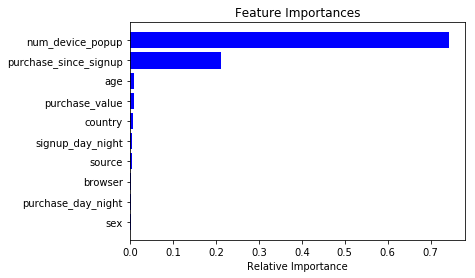

In [126]:
import matplotlib.pyplot as plt

importance=clf.best_estimator_.feature_importances_
features=x.columns
indices = np.argsort(importance)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

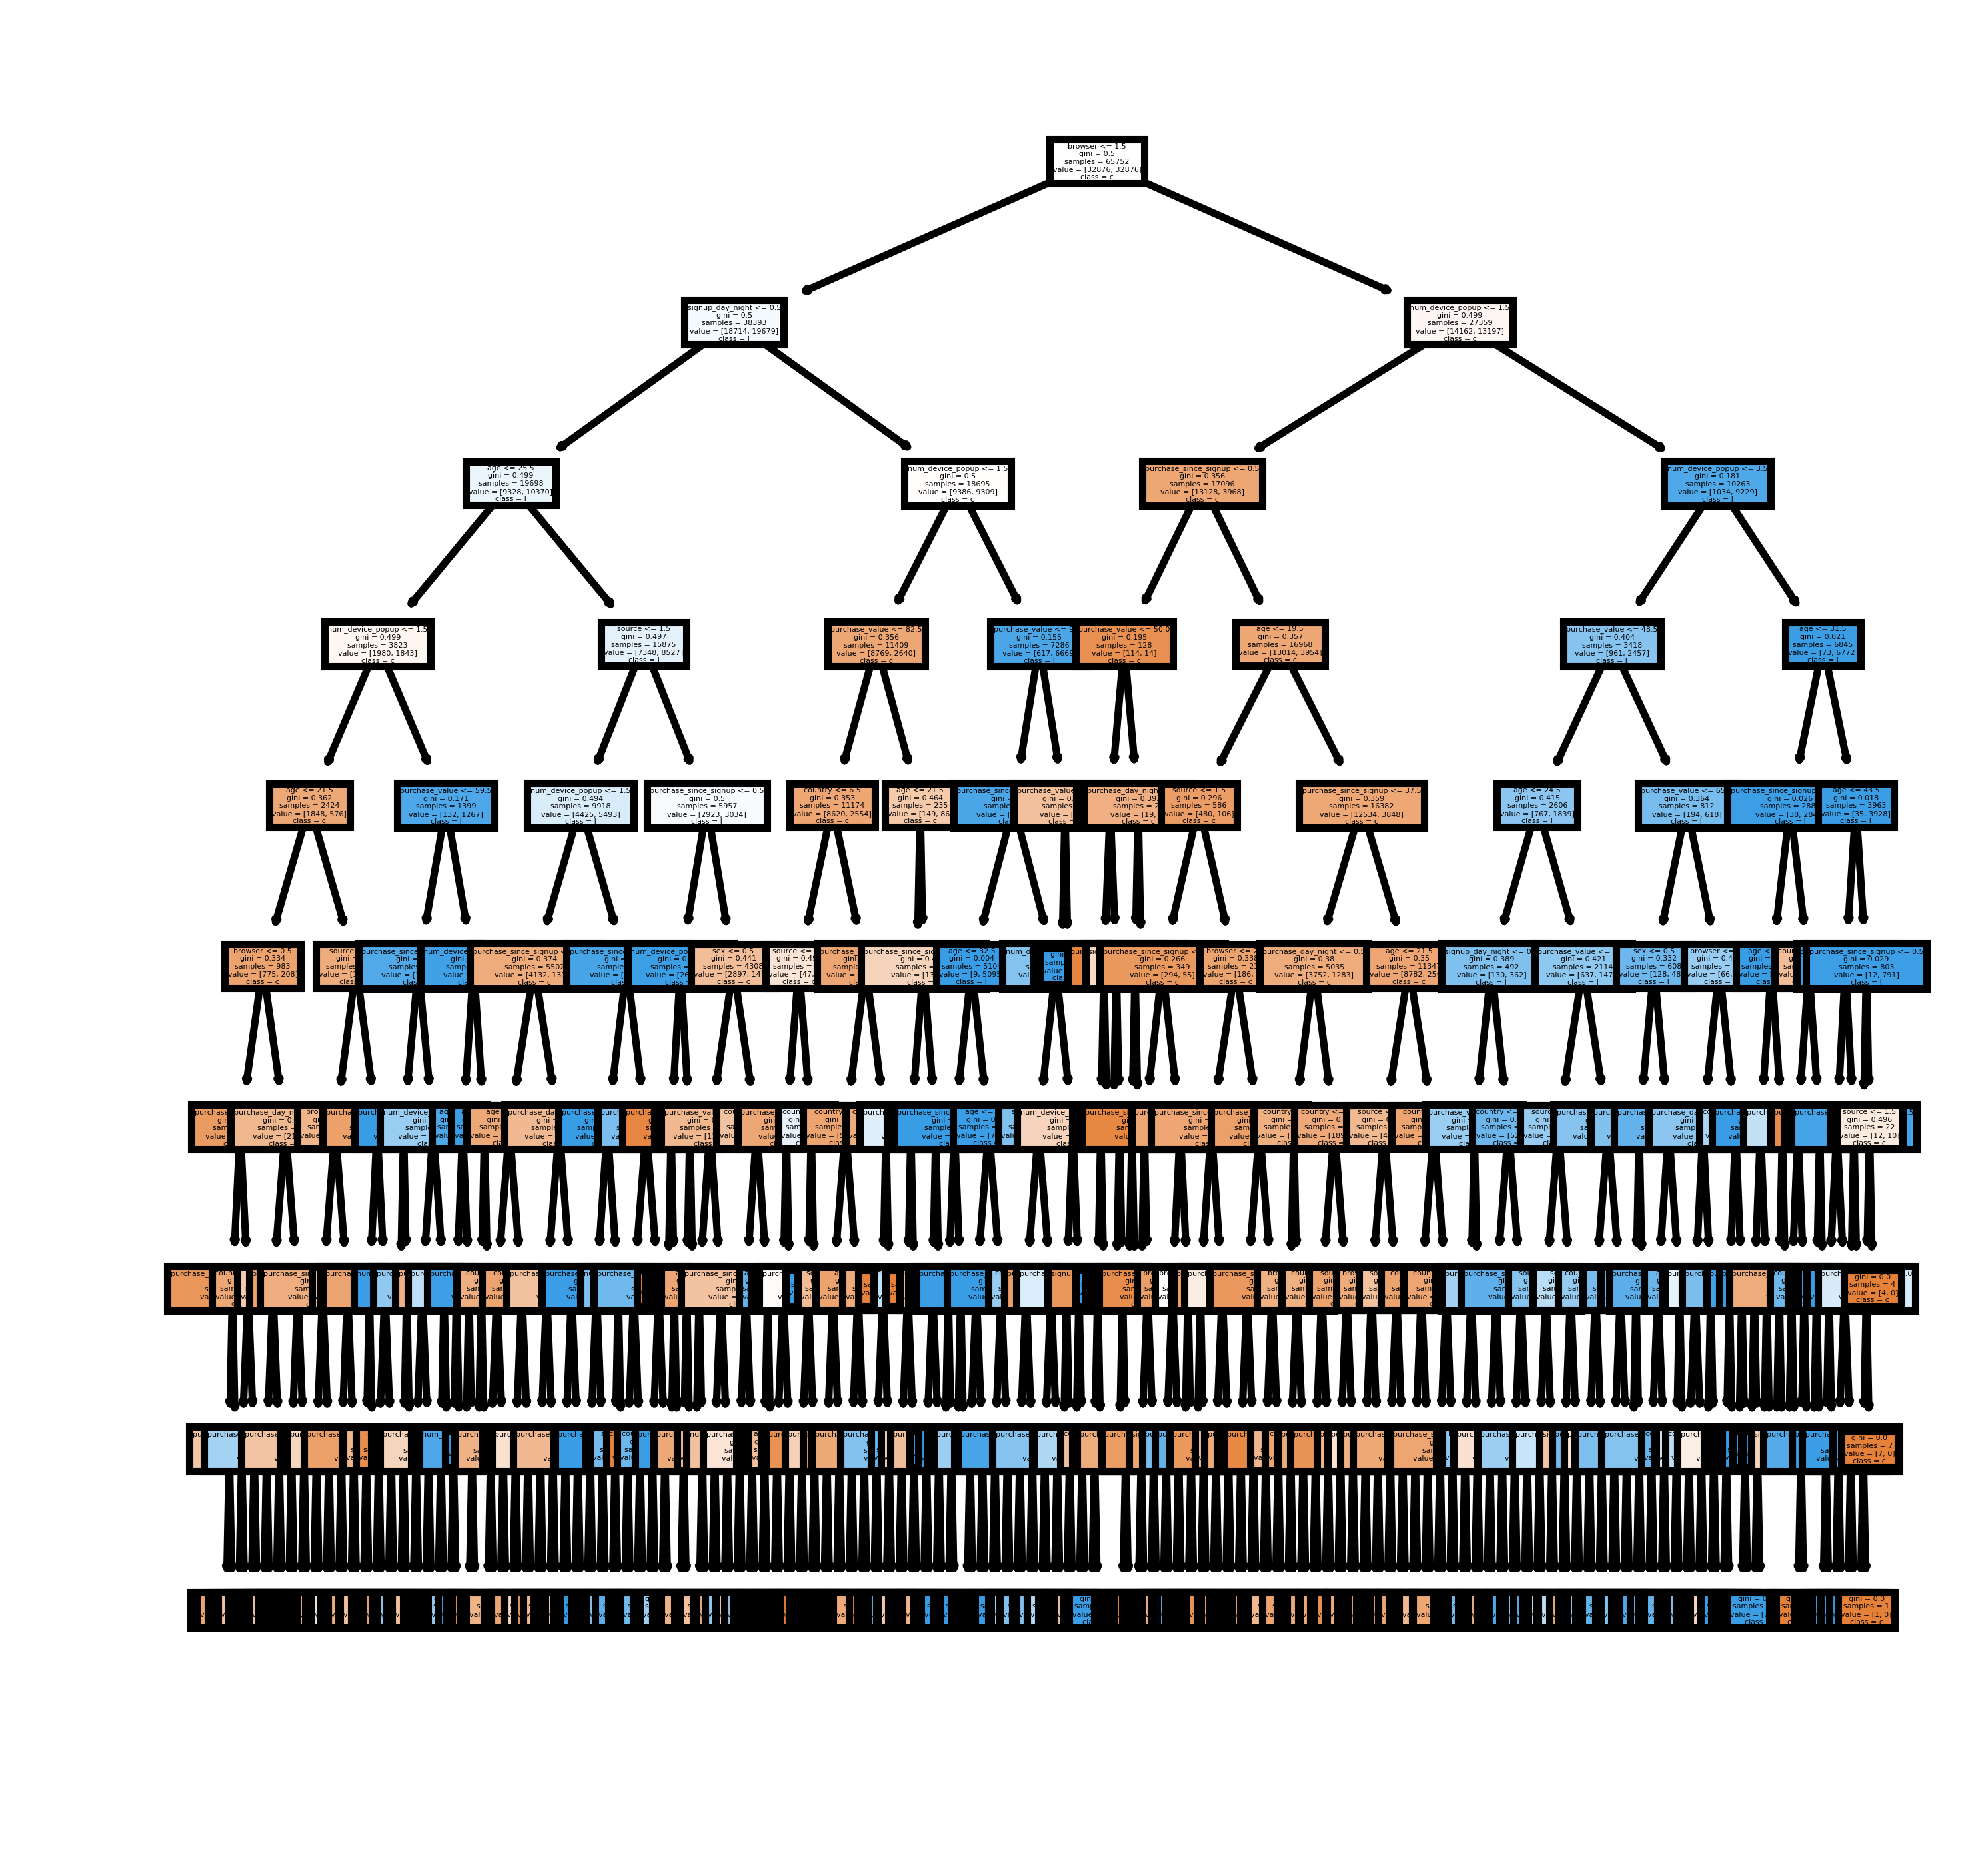

In [139]:
estimator=clf.best_estimator_.estimators_[5]

from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(estimator,
               feature_names = features, 
               class_names=y.name,
               filled = True)
fig.savefig('rf_individualtree.png')

# smote